In [1]:
import os
import math
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.
c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

## Model

In [3]:
model = Sequential()
model.add(LSTM(64, input_shape=(10, 4), return_sequences=True ))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear', use_bias=True))

model.summary()
model.compile(loss='mse', optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            17664     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [4]:
def train(model, x, y, epochs, batch_size):
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
        
        callbacks = [EarlyStopping(monitor='val_loss', patience=2),]
        model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=callbacks)

In [5]:
def predict_point_by_point(model, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting Point-by-Point...')
        predicted = model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

In [21]:
def plot_results(predicted_data, true_data , title ):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.show()

Predicting 10 days...


W1109 10:15:06.953959 14596 deprecation_wrapper.py:119] From c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



513
513
[Model] Predicting Point-by-Point...
loss  [2.58698778]


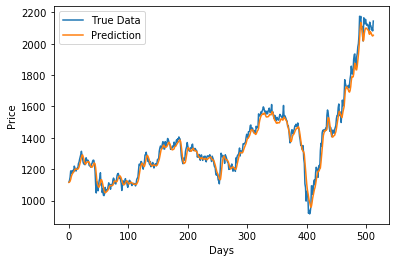

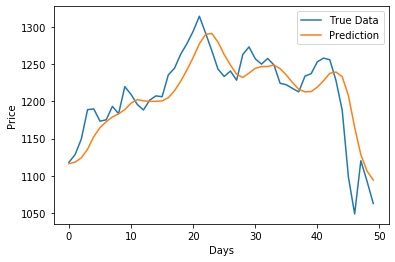

In [7]:
lossesMINE = []
lossesKERAS = []
split_ratio = 0.9
day_prediction = 10

x = np.load("data/train_x.npy")
y = np.load("data/test_y.npy")

length_of_train = int(len(x)*split_ratio)

x_train = x[: length_of_train]
y_train = y[:length_of_train]
Is_trained = True
if Is_trained == False :
    train( model, x_train, y_train , 15 , 256  )
else:
    model.load_weights("output/lstm/weight.h5")
x_test = x[length_of_train:]
y_test = y[length_of_train :-1]

print(len(x_test))
print(len(y_test))


predictions = predict_point_by_point(model , x_test)

npPredictions = np.asarray(predictions)

loss = 0
for i in range(len(npPredictions)):
    loss += (npPredictions[i] - y_test[i])**2
print("loss ",loss)

mean = np.load("data/mean.npy")[3]
std =np.load("data/std.npy")[3]

real_y = np.reshape(y_test, (y_test.shape[0], ))*std + mean
real_pred = predictions*std +mean

plot_results(real_pred, real_y)
plot_results(real_pred[:50], real_y[:50])

In [8]:
model.predict(x_test[:1]).shape

(1, 1)

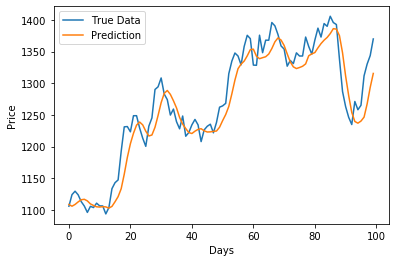

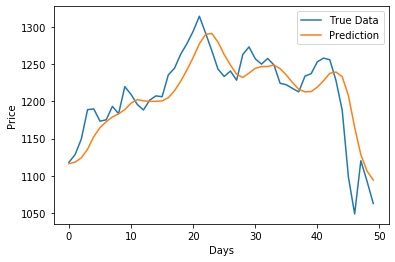

In [9]:
plot_results(real_pred[100:200], real_y[100:200])
plot_results(real_pred[:50], real_y[:50])

In [15]:
from numpy import newaxis
import random
def predict_multiple_days(model ,data  , days_to_predict , seq_len , y_actual ):
    print('[Model] Predicting Sequences Multiple...')
    loss = []
    prediction_seqs = []
    y_actual_seqs = []
    for i in range(len(data) - days_to_predict-1):
            curr_frame = data[i]
            #print("frame  ",curr_frame)
            predicted = []
            loss_temp = []
            y_ac =[]
            for j in range(days_to_predict):
                #print("frame  ",curr_frame)
                #print("new Axis",newaxis)
                predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0] )
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, seq_len-1, predicted[-1]+ random.uniform(-0.05 , 0.05), axis=0)
                loss_temp.append((y_actual[i+j][0] - predicted[-1] )**2)
                y_ac.append(y_actual[i+j][0])
            loss.append(loss_temp)
            prediction_seqs.append(predicted)
            y_actual_seqs.append(y_ac)
    return prediction_seqs , loss , y_actual_seqs

In [16]:
prediction_seqs , loss , y_actual_seqs = predict_multiple_days(model,x_test , 50 , 10 , y_test)

[Model] Predicting Sequences Multiple...


0


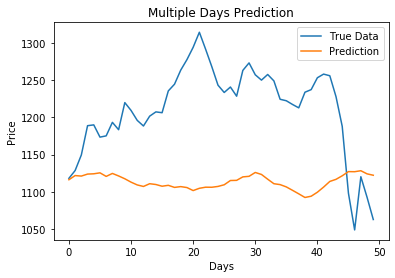

1


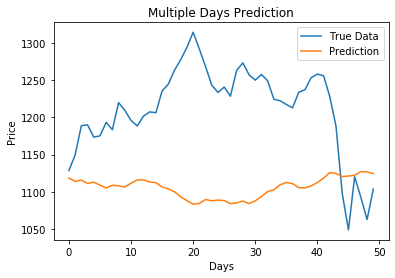

2


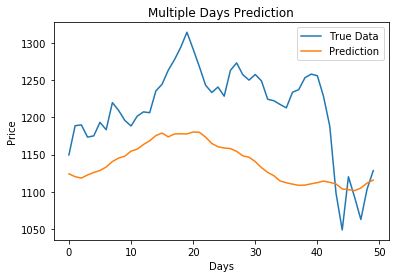

3


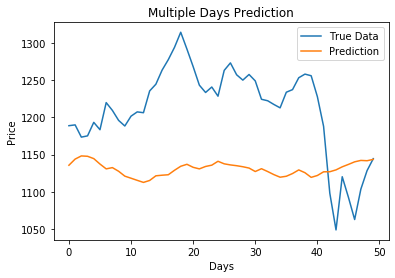

4


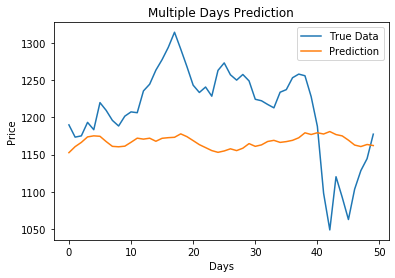

5


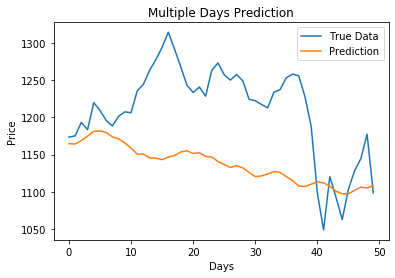

6


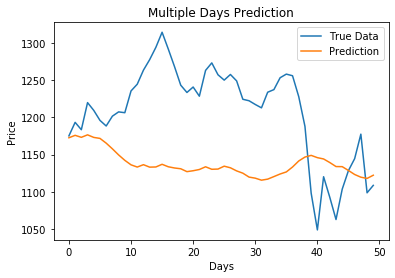

7


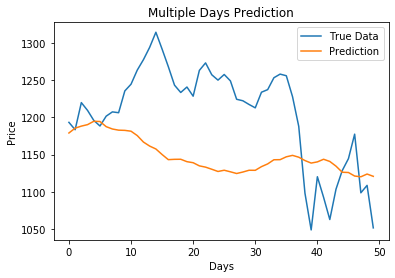

8


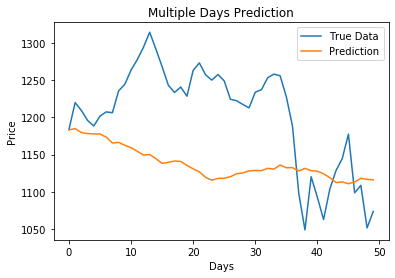

9


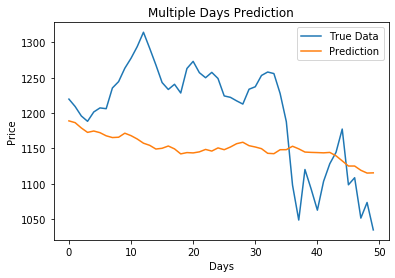

10


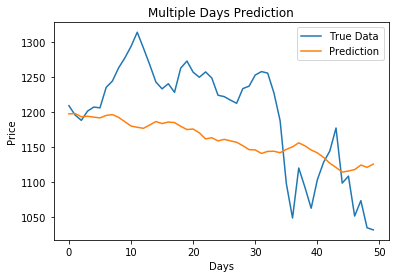

11


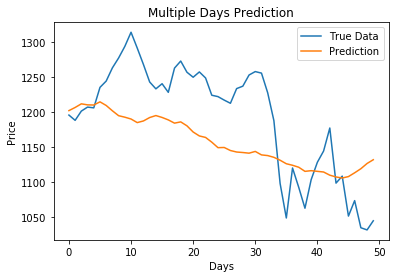

12


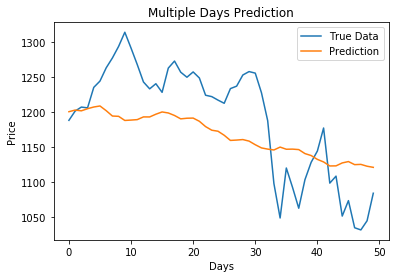

13


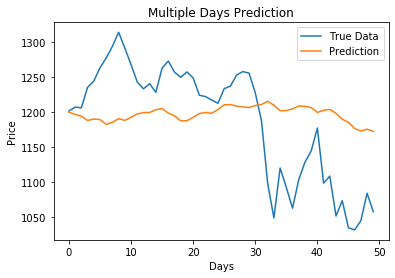

14


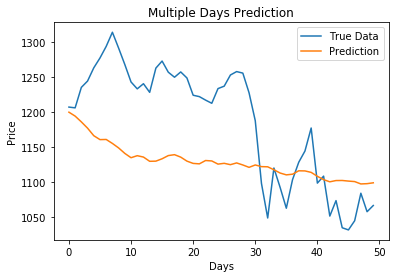

15


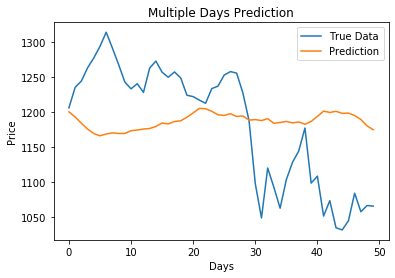

16


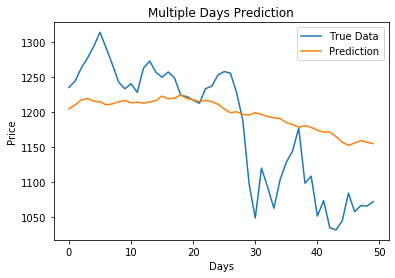

17


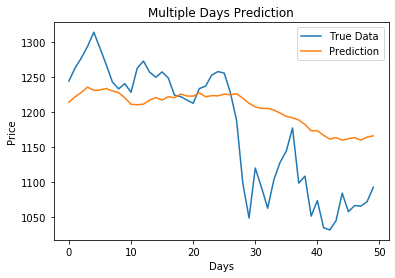

18


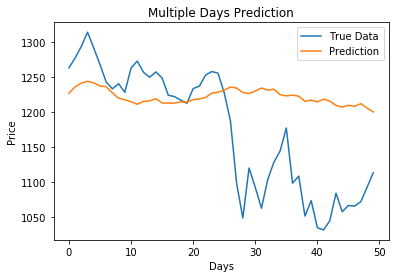

19


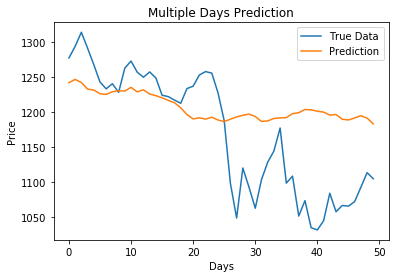

20


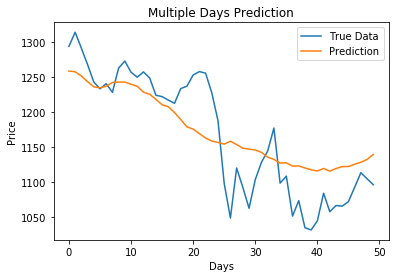

21


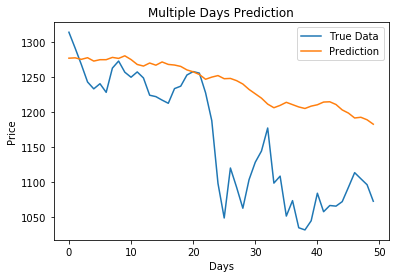

22


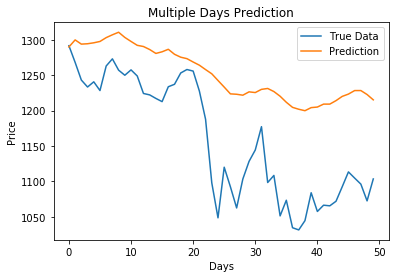

23


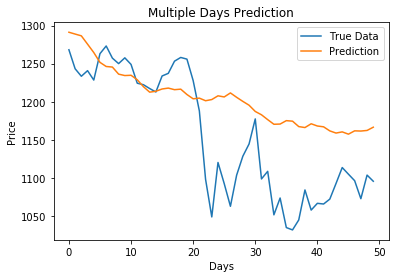

24


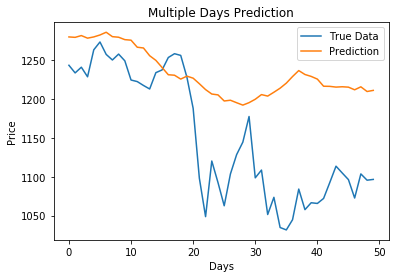

25


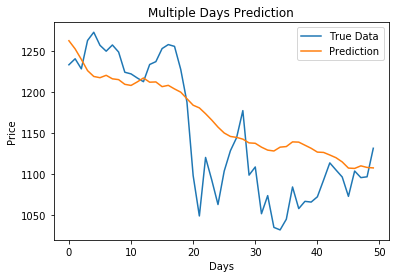

26


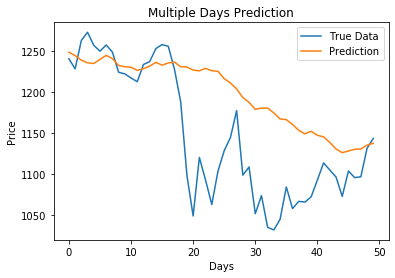

27


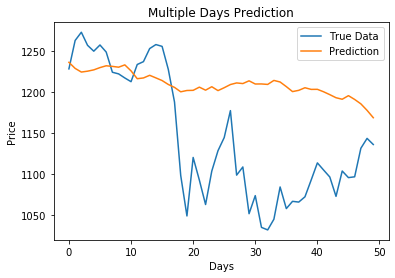

28


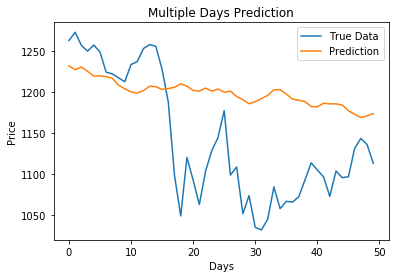

29


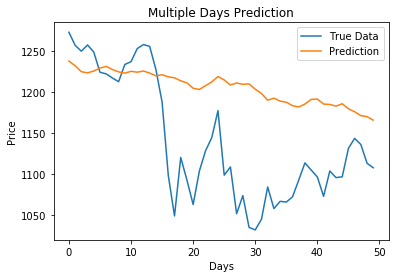

30


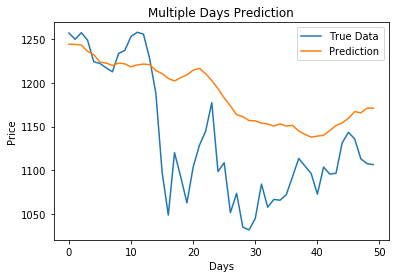

31


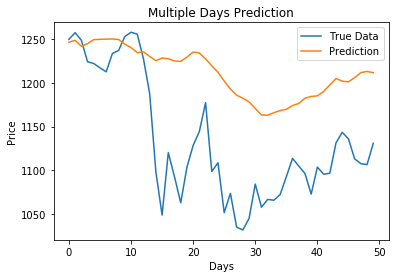

32


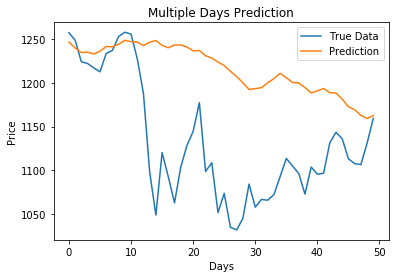

33


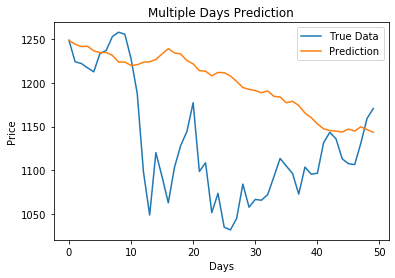

34


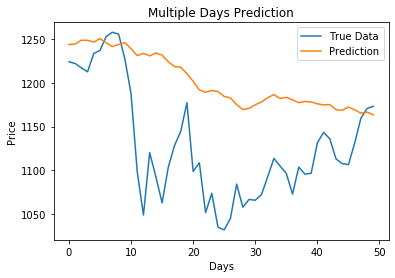

35


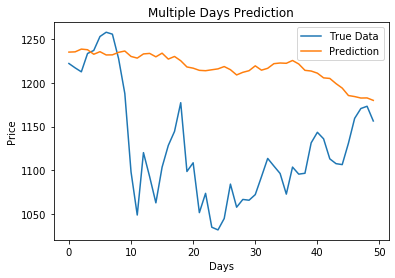

36


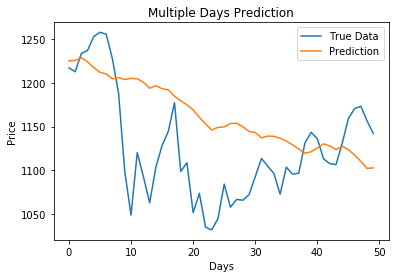

37


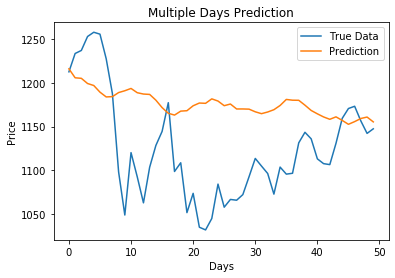

38


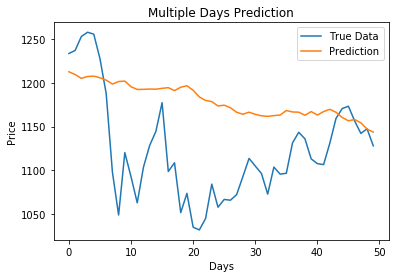

39


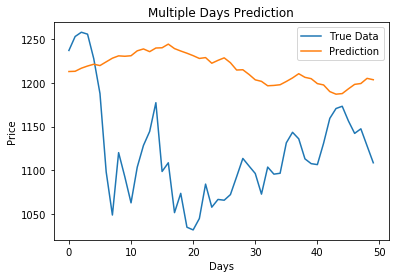

40


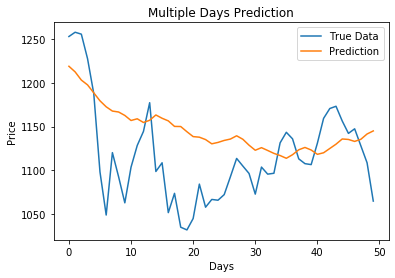

41


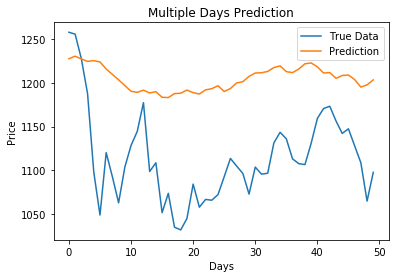

42


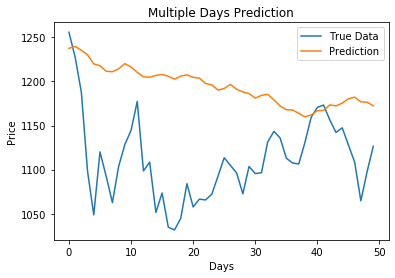

43


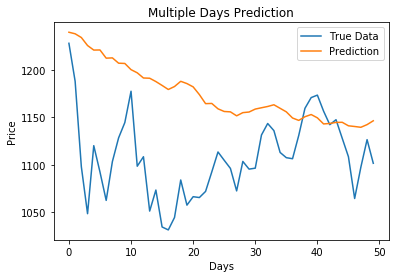

44


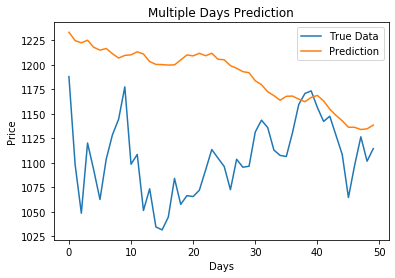

45


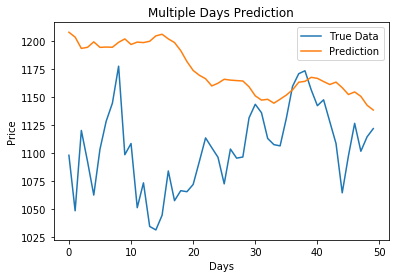

46


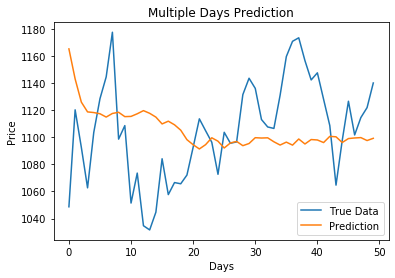

47


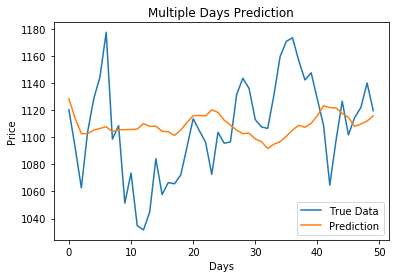

48


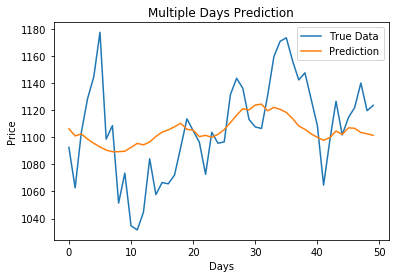

49


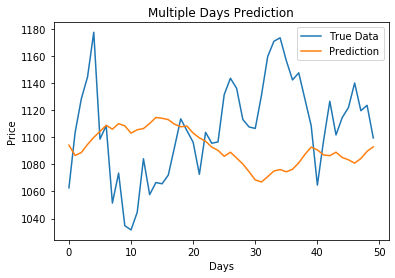

50


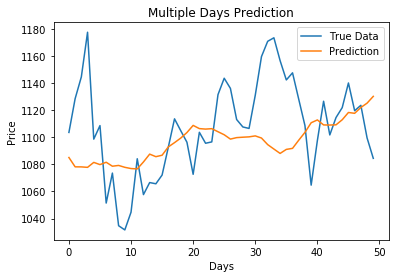

51


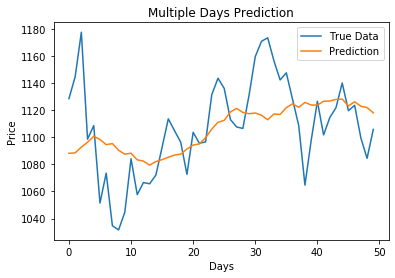

52


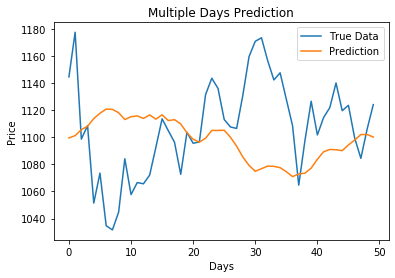

53


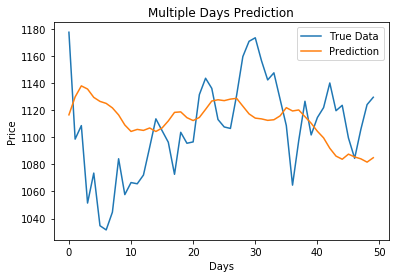

54


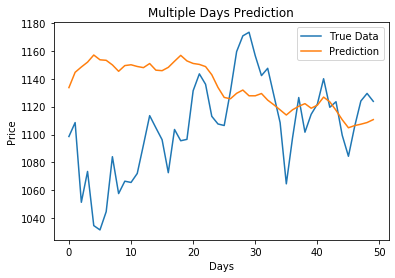

55


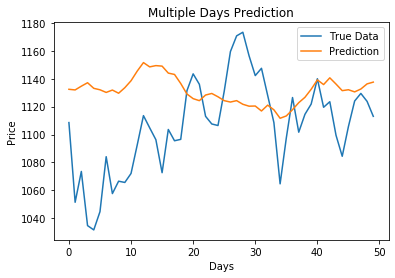

56


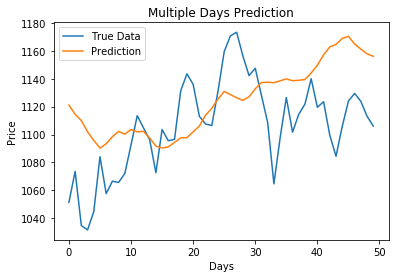

57


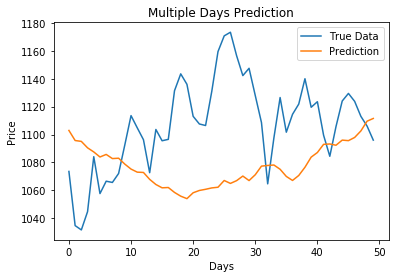

58


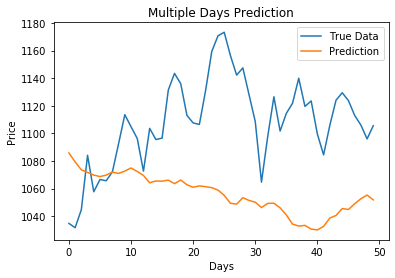

59


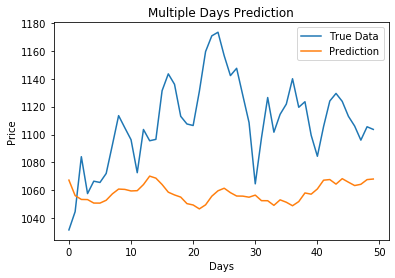

60


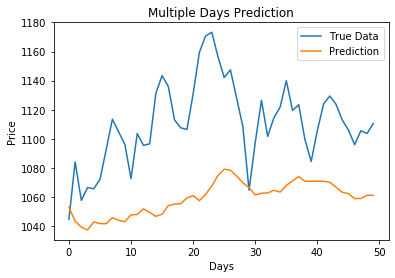

61


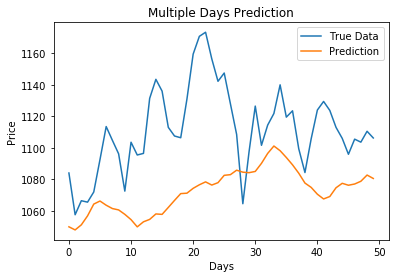

62


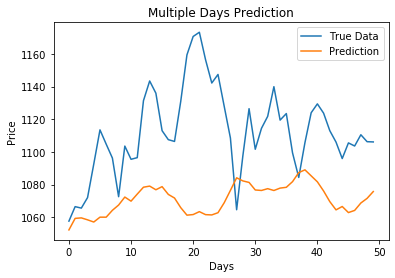

63


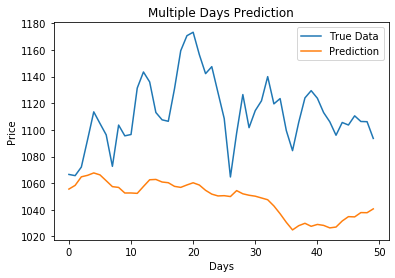

64


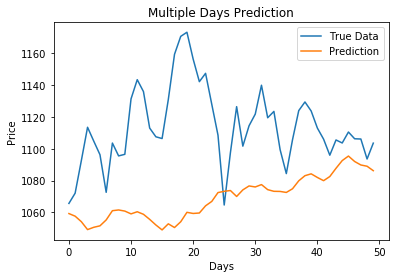

65


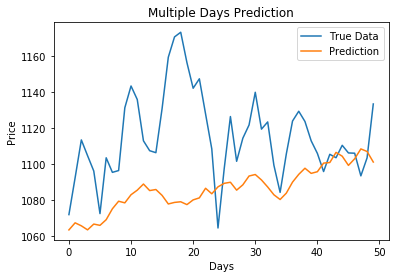

66


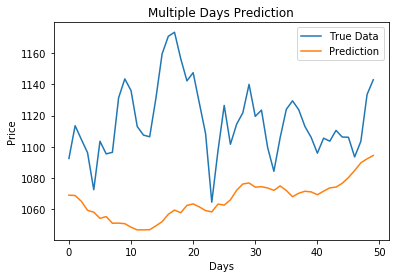

67


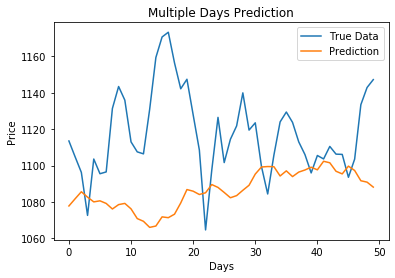

68


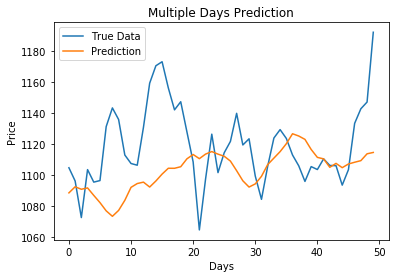

69


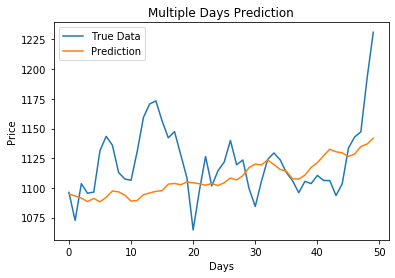

70


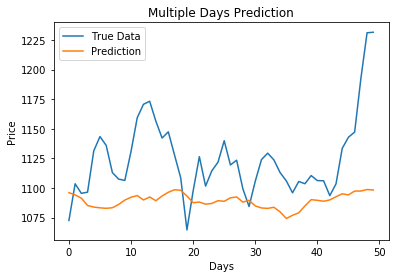

71


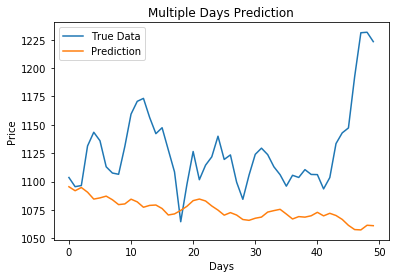

72


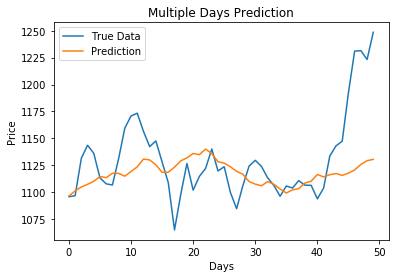

73


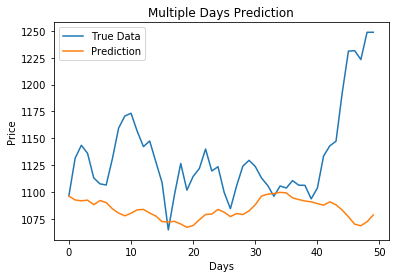

74


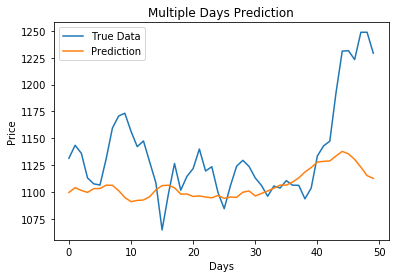

75


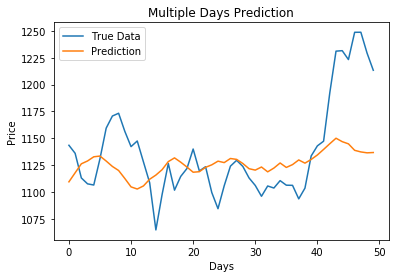

76


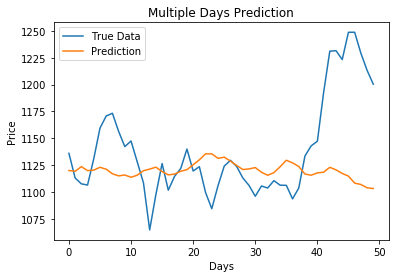

77


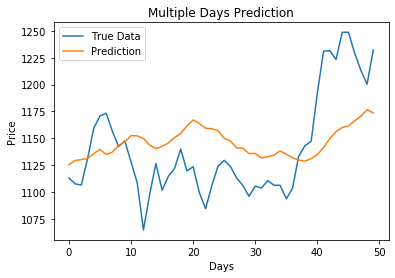

78


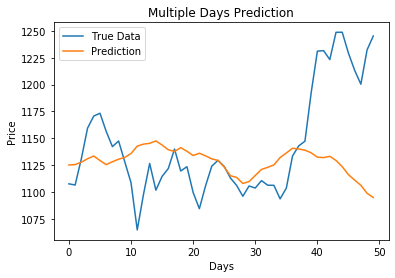

79


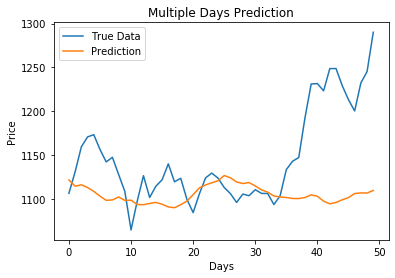

80


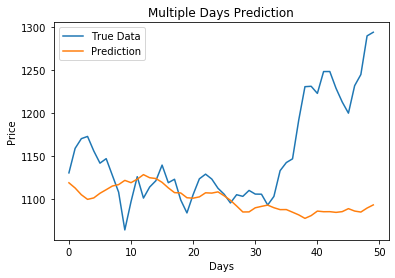

81


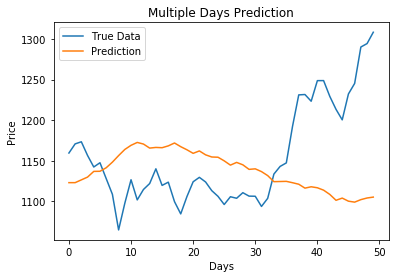

82


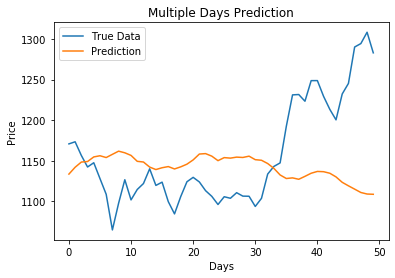

83


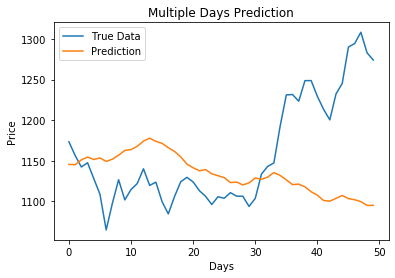

84


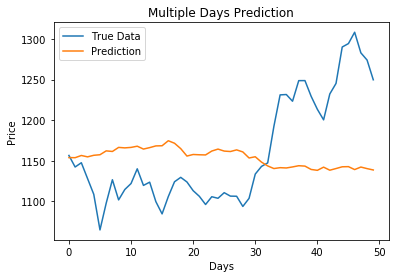

85


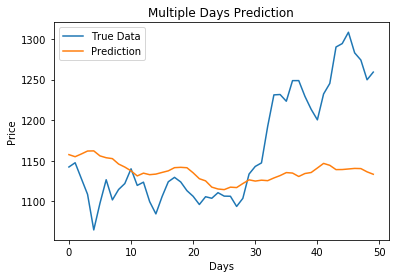

86


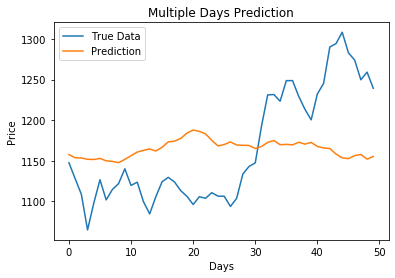

87


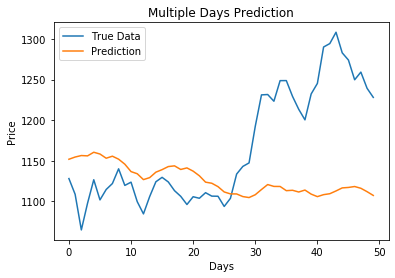

88


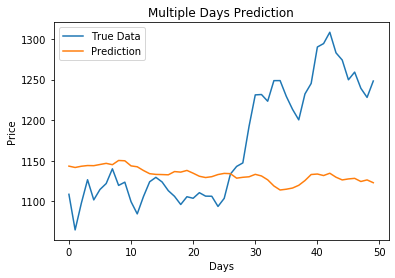

89


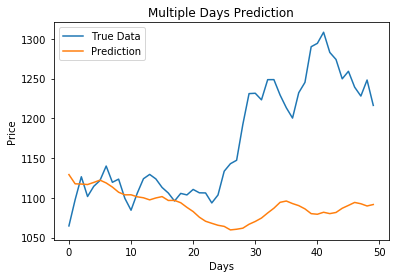

90


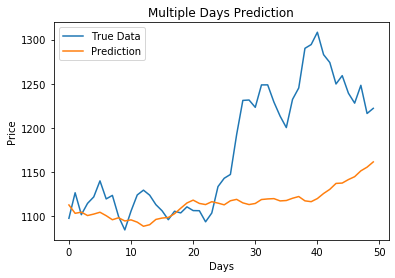

91


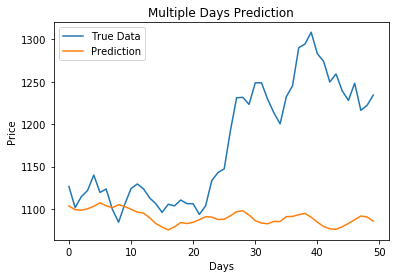

92


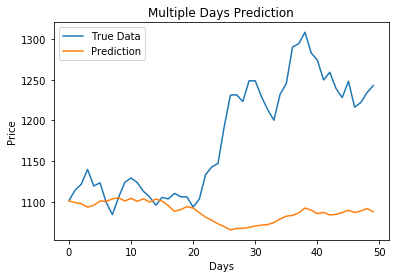

93


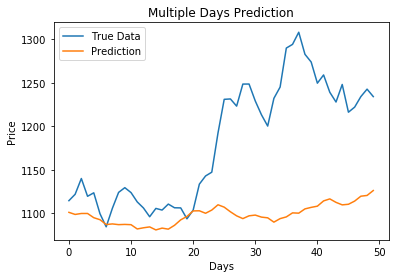

94


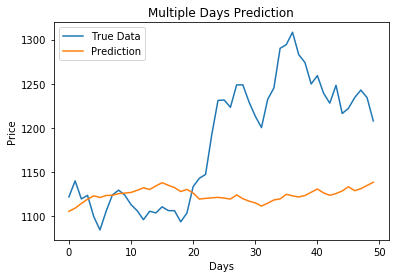

95


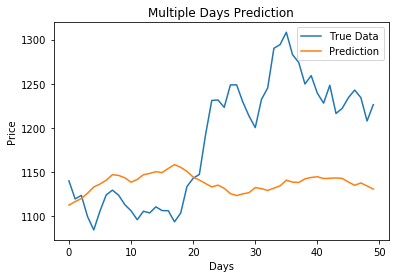

96


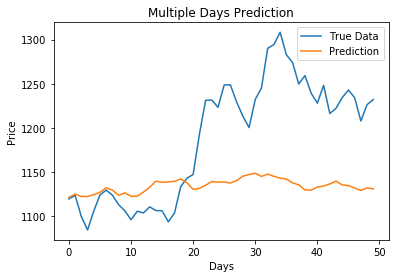

97


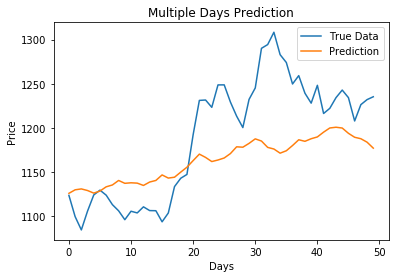

98


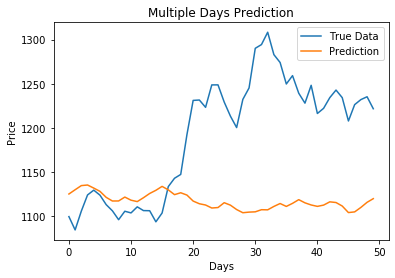

99


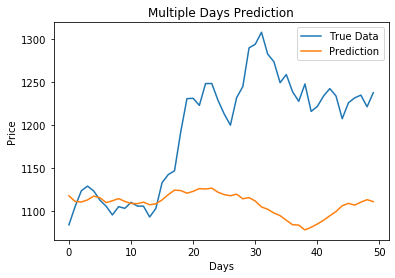

In [22]:
for d in range (100):
    prediction_seqs = np.array(prediction_seqs)
    y_actual_seqs = np.array(y_actual_seqs)
    size = 15
    print(d)
    plot_results(prediction_seqs[d]*std + mean ,y_actual_seqs[d]*std + mean , "Multiple Days Prediction" )

In [23]:
y_test.shape

(513, 1)

In [22]:
def avg_loss(loss):
    loss = np.array(loss)
    return np.average(loss ,axis=0)

In [23]:
avgloss = avg_loss(loss)

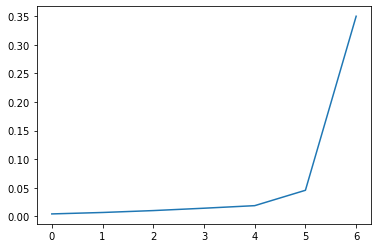

In [24]:
print_loss = []
print_loss.append(avgloss[0])
print_loss.append(avgloss[1])
print_loss.append(avgloss[2])
print_loss.append(avgloss[3])
print_loss.append(avgloss[4])
print_loss.append(avgloss[9])
print_loss.append(avgloss[49])

plt.plot(print_loss)

## Performance Measures
### multiple days predictions

In [12]:
model.load_weights("output/lstm/weight.h5")

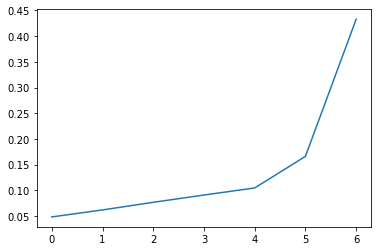

In [27]:
#Mean Absolute Error
def MeanAbsoluteError(loss):
    loss = np.array(loss)
    loss = loss**(0.5)
    loss = np.array(loss)
    avgloss =  np.average(loss ,axis=0)
    
    print_loss = []
    print_loss.append(avgloss[0])
    print_loss.append(avgloss[1])
    print_loss.append(avgloss[2])
    print_loss.append(avgloss[3])
    print_loss.append(avgloss[4])
    print_loss.append(avgloss[9])
    print_loss.append(avgloss[49])
  
    plt.plot(print_loss)
    return avgloss

mae  = MeanAbsoluteError(loss)



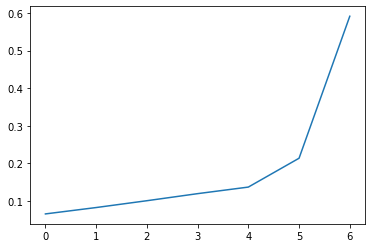

In [26]:
# Root Mean Squared Error
def rms(loss):
    loss = np.array(loss)
    print_loss = []
    avgloss = np.sqrt ( np.average(loss ,axis=0))    
    print_loss.append(avgloss[0])
    print_loss.append(avgloss[1])
    print_loss.append(avgloss[2])
    print_loss.append(avgloss[3])
    print_loss.append(avgloss[4])
    print_loss.append(avgloss[9])
    print_loss.append(avgloss[49])
  
    plt.plot(print_loss)
    return avgloss
rms = rms(loss)

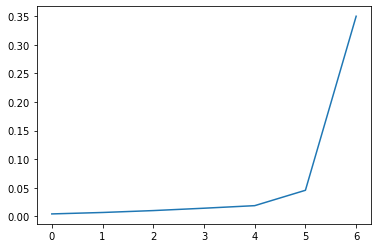

In [28]:
# Mean Squared Error
def mse(loss):
    loss = np.array(loss)
    print_loss = []
    avgloss = np.average(loss ,axis=0)   
    print_loss.append(avgloss[0])
    print_loss.append(avgloss[1])
    print_loss.append(avgloss[2])
    print_loss.append(avgloss[3])
    print_loss.append(avgloss[4])
    print_loss.append(avgloss[9])
    print_loss.append(avgloss[49])
  
    plt.plot(print_loss)
    return avgloss
mse = mse(loss)

In [32]:
# R2 Square
from sklearn.metrics import mean_squared_error , r2_score
import math
def r2square(ytest , ypred) :
    ytest = np.array(ytest)
    ypred = np.array(ypred)
    loss =[]
    for i in range (50):
        loss.append(r2_score(ytest[:,i] , ypred[:,i]) )
    return loss
r2 = r2square(prediction_seqs , y_actual_seqs)
print(r2)

[0.9377823860910508, 0.8976651712766149, 0.839801005596317, 0.7606636563517954, 0.6644647653690542, 0.5496045778045067, 0.41248497763632863, 0.24919961706863214, 0.05850806557754118, -0.1617558604727114, -0.40326106731369493, -0.6873494565333063, -1.0038680404140803, -1.3570620188448048, -1.7574881711698556, -2.183318576450845, -2.6380925634533017, -3.124052294126635, -3.6680150502262565, -4.267927450667009, -4.914012187417419, -5.559279210097752, -6.237948846941025, -6.991263508084798, -7.802138529063802, -8.69175522500707, -9.653471861260998, -10.714920852545449, -11.948427101981444, -13.229789973507566, -14.609617712591357, -15.993104219540047, -17.476634394639643, -18.982770950121186, -20.547573284406308, -22.384039518182217, -24.313806884415822, -26.31837812132123, -28.48044639718089, -30.732144018879815, -33.0953902037002, -35.599259768455106, -38.230703665941355, -40.97567188546101, -43.8399713523838, -46.96652541296359, -50.22050114740728, -53.628969524392204, -57.1553034310766

In [36]:
def Save_Performance_Measures():
    np.save("Performance Measures/lstm/r2",r2)
    np.save("Performance Measures/lstm/mse",mse)
    np.save("Performance Measures/lstm/rms",rms)
    np.save("Performance Measures/lstm/mae",mae)
    np.save("Performance Measures/lstm/pred_seqs",prediction_seqs)
    np.save("Performance Measures/lstm/actual_seqs",y_actual_seqs)
    np.save("Performance Measures/lstm/real_pred",real_pred)
    np.save("Performance Measures/lstm/real_y",real_y)